In [1]:
from itertools import cycle

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model ,Sequential #for CNN
from keras.layers import Dense 
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, Flatten, Dense, Activation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling', 
                 'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Class=247, n=22 (0.054%)
Class=248, n=22 (0.054%)
Class=249, n=22 (0.054%)
Class=250, n=22 (0.054%)
Class=251, n=22 (0.054%)
Class=252, n=22 (0.054%)
Class=253, n=22 (0.054%)
Class=254, n=22 (0.054%)
Class=255, n=22 (0.054%)
Class=256, n=22 (0.054%)
Class=257, n=22 (0.054%)
Class=258, n=22 (0.054%)
Class=259, n=22 (0.054%)
Class=260, n=22 (0.054%)
Class=261, n=22 (0.054%)
Class=262, n=22 (0.054%)
Class=263, n=22 (0.054%)
Class=264, n=21 (0.051%)
Class=265, n=21 (0.051%)
Class=266, n=21 (0.051%)
Class=267, n=21 (0.051%)
Class=268, n=21 (0.051%)
Class=269, n=20 (0.049%)
Class=270, n=20 (0.049%)
Class=271, n=20 (0.049%)
Class=272, n=20 (0.049%)
Class=273, n=20 (0.049%)
Class=274, n=20 (0.049%)
Class=275, n=20 (0.049%)
Class=276, n=20 (0.049%)
Class=277, n=20 (0.049%)
Class=278, n=20 (0.049%)
Class=279, n=20 (0.049%)
Class=280, n=19 (0.046%)
Class=281, n=19 (0.046%)
Class=282, n=19 (0.046%)
Class=283, n=18 (0.044%)
Class=284, n=18 (0.044%)
Class=285, n=18 (0.044%)
Class=286, n=18 (0.044%)

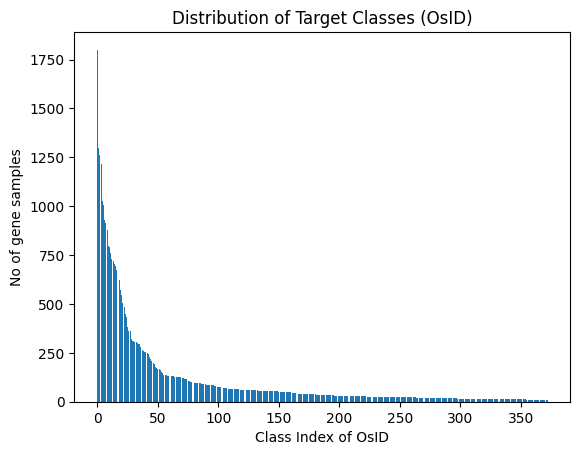

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [8]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []

for i in range(1, 21):

  models_fold = []
  hist = []
  train_accuracy = []
  train_loss = []
  val_accuracy = []
  val_loss = []
  test_accuracy = []

  print("\nNumber of input features:", i)

  # Select the input features from the input data
  X_train_selected = X_train[:, :i]
  X_test_selected = X_test[:, :i]

  X_train_selected = X_train_selected.reshape(27543, i, 1, 1)
  X_test_selected = X_test_selected.reshape(13567, i, 1, 1)

  # Loop over the folds
  for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

    print("Fold:", fold+1)

    # Build the model
    model = Sequential()
    model.add(Conv2D(60, kernel_size=(5,5), activation='relu',bias_initializer='normal', input_shape=X_train_selected.shape[1:], padding= "same")) #keeps the output size same as input size (prevent down or upsampling)
    model.add(MaxPooling2D(pool_size=(1,1))) #pool size 2 error, because 1 (1 feature) minus 2 (pool size) is negative)
    model.add(Flatten())
    model.add(Dense(20, bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20, bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373, kernel_initializer='normal', activation='softmax'))

    # compile model
    model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics = ['accuracy']) 

    # # Fit the model to the training data for the current fold
    history = model.fit(X_train_selected[train_index], to_categorical(y_train_enc[train_index], num_classes=373), batch_size = 5, epochs = 20, verbose = 1, validation_split = 0.33)

    # Evaluate the model on the validation data for the current fold
    val_scores = model.evaluate(X_train_selected[val_index], to_categorical(y_train_enc[val_index],num_classes=373), verbose=0)
    val_accuracy.append(val_scores[1])
    val_loss.append(val_scores[0])

    # Evaluate the model on the test data for the current fold
    test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
    test_accuracy.append(test_scores[1])

    # add the model to the list of models
    models_fold.append(model)
    hist.append(history)

    # store the training accuracy and loss for each fold
    train_accuracy.append(history.history['accuracy'])
    train_loss.append(history.history['loss'])
  
  # Calculate the average test and validation accuracy and loss across all folds
  avg_test_acc = sum(test_accuracy) / len(test_accuracy)
  avg_val_acc = sum(val_accuracy) / len(val_accuracy)
  avg_val_loss = sum(val_loss) / len(val_loss)

  # Print the average validation and test accuracy and loss
  print("Average Validation Accuracy:", avg_val_acc)
  print("Average Validation Loss:",avg_val_loss)
  print("Average Test Accuracy:", avg_test_acc)

  best_fold_index = test_accuracy.index(max(test_accuracy))
  model_accuracy.append(test_accuracy[best_fold_index])
  models.append(models_fold[best_fold_index])
  model_history.append(hist[best_fold_index])
  model_train_acc.append(train_accuracy[best_fold_index])
  model_train_loss.append(train_loss[best_fold_index])
  model_val_acc.append(val_accuracy[best_fold_index])
  model_val_loss.append(val_loss[best_fold_index])
  print('------------------------------------------------------------------------')


Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.6514 - accuracy: 0.0828 - val_loss: 4.2778 - val_accuracy: 0.1155
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9828 - accuracy: 0.1397 - val_loss: 3.9588 - val_accuracy: 0.1875
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6721 - accuracy: 0.1758 - val_loss: 3.7149 - val_accuracy: 0.2163
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3900 - accuracy: 0.2208 - val_loss: 3.4707 - val_accuracy: 0.2339
Epoch 5/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1628 - accuracy: 0.2446 - val_loss: 3.3104 - val_accuracy: 0.2374
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9822 - accuracy: 0.2746 - val_loss: 3.2032 - val_accuracy: 0.2343
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8609 - accuracy: 0.29

In [9]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

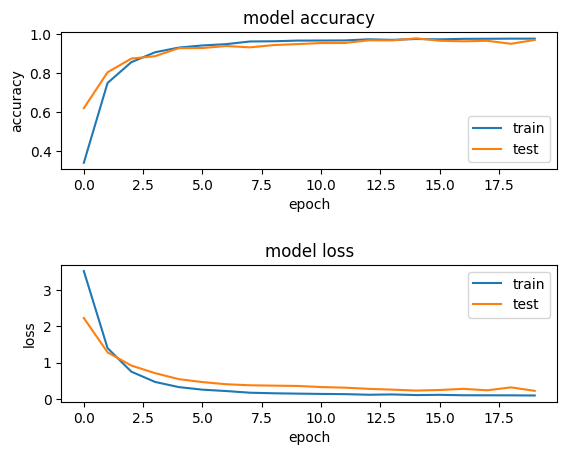

Final Test Accuracy: 0.9814255237579346


In [10]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [20]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

X_test = X_test.reshape(13567, best_model_index+1, 1, 1)

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              280       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [22]:
display(models_df)

,No of input features,Model accuracy
0,1,0.409
1,2,0.724
2,3,0.879
3,4,0.926
4,5,0.955
5,6,0.967
6,7,0.975
7,8,0.974
8,9,0.973
9,10,0.974
